# Kohonen Network

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import statistics
from tqdm import tqdm

In [3]:
def gauss_nhood(x, t=None):
    if t is None:
        t = 1
    return np.exp(-(x * t) ** 2)

def mexican_hat_nhood(x, t=None):
    if t is None:
        t = 1
    return (2 - 4*((x*t) ** 2)) * np.exp(-(x * t) ** 2)

def exp_decay(t, lambda_max):
    """ t: current interation """
    return np.exp(-t / lambda_max)

def euclidean_distance(a, b):
    return np.linalg.norm(np.subtract(a, b), ord=2, axis=-1)

In [24]:
class KOH:

    def __init__(self, input_dim, shape, distance_metric=euclidean_distance, decay_function=exp_decay,
                 neighborhood_function=gauss_nhood, initialization='random', topology='normal'):
        """
        input_dim: number of input vectors, neuron dim
        shape: tuple (N, M)
        topology: 'normal' or 'hexagonal'
        """
        assert len(shape) == 2
        self.input_dim = input_dim
        self.shape = shape
        self.indices = np.array(list(np.ndindex(self.shape)), dtype=float)
        if topology == 'hexagonal' or topology == 'hexagon':
            self.transform_to_hexagonal()
        self.weights = self.random_init()
        self.distance_metric = distance_metric
        self.decay_function = decay_function
        self.neighborhood_function = neighborhood_function
        self.data = None
    
    def random_init(self):
        return np.random.standard_normal(
            size=(self.shape[0], self.shape[1], self.input_dim)
        )

    def transform_to_hexagonal(self):
        for k in range(self.shape[0]):
            self.indices[k*self.shape[1]:k*self.shape[1]+self.shape[1]][:, 0] = self.indices[k*self.shape[1]:k*self.shape[1]+self.shape[1]][:, 0] * np.sqrt(3) / 2
            if k % 2 == 1:
                self.indices[k*self.shape[1]:k*self.shape[1]+self.shape[1]][:, 1] = self.indices[k*self.shape[1]:k*self.shape[1]+self.shape[1]][:, 1] + 0.5
    
    def nhood_weight(self, n1, n2, t=None, r=None):
        """ calculates neighborhood distance """
        if r is None:
            r = 1
        return self.neighborhood_function(self.distance_metric(n1, n2) * r, t)

    def find_bmu(self, x):
        """ finds best matching unit """
        index = np.argmin(self.distance_metric(self.weights, x))
        return np.unravel_index(index, self.shape)
    
    def get_weights(self, indices):
        """ get weights from indices """
        return self.weights[indices[0]][indices[1]]
                    
    def update_weights(self, x, bmu, t, lambda_max, r, use_nhood_decay=False, learning_rate=None):
        """ updates weights """
        time = None
        if use_nhood_decay:
            time = t
        if learning_rate is None:
            learning_rate = 1
        nhood_weights = self.nhood_weight(bmu, self.indices, time, r)
        nhood_weights = nhood_weights.reshape(self.shape)
        nhood_weights_tensor = np.stack((nhood_weights, ) * self.input_dim, axis=2)
        
        self.weights = self.weights + exp_decay(t, lambda_max) * nhood_weights_tensor * (x - self.weights) * learning_rate

    def predict(self, data):
        predictions = []
        for x in data:
            predictions.append(np.argmin(self.distance_metric(self.weights, x)))
        return np.array(predictions)
    
    def train(self, data, lambda_max, r=None, use_nhood_decay=False, learning_rate=None):
        """ 
        lambda_max: number of iterations
        """
        self.data = data
        shuffled_data = np.copy(data)
        np.random.shuffle(shuffled_data)
        
        for t in tqdm(range(1, lambda_max+1)):
            for x in shuffled_data:
                bmu_indices = self.find_bmu(x)
                self.update_weights(x, bmu_indices, t, lambda_max, r, use_nhood_decay, learning_rate)

    def plot_clusters(self, labels, type='hex', return_plot=False):
        """ labels: pandas series """
        if type == 'hex':
            weights_res = self.weights.reshape(-1, 2)
            sns.scatterplot(x=self.data[:,0], y=self.data[:,1], hue=labels.to_numpy())
            sns.scatterplot(x=weights_res[:,0], y=weights_res[:,1])
        elif type == 'cube':
            weights_res = self.weights.reshape(-1, 3)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(self.data[:,0], self.data[:,1], self.data[:,2], c=labels.to_numpy(), marker='o', alpha=0.2)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.scatter(weights_res[:,0], weights_res[:,1], weights_res[:,2], c='k', alpha=1)
        if return_plot:
            return plt
        else:
            plt.show()

## Data

In [5]:
hexagon = pd.read_csv("dane/hexagon.csv")
cube = pd.read_csv("dane/cube.csv")

In [6]:
hex_train = hexagon[['x', 'y']].to_numpy()
cube_train = cube[['x', 'y', 'z']].to_numpy()

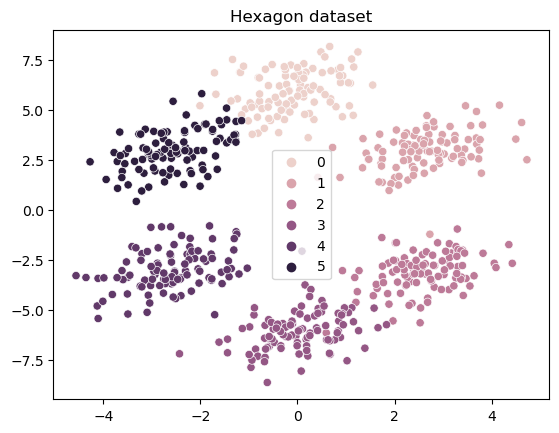

In [7]:
sns.scatterplot(x=hex_train[:,0], y=hex_train[:,1], hue=hexagon['c'].to_numpy()).set_title('Hexagon dataset')
plt.show()

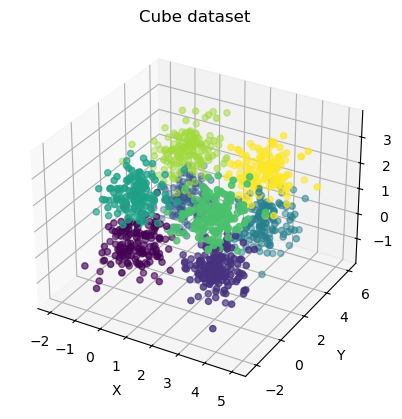

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_train[:,0], cube_train[:,1], cube_train[:,2], c=cube['c'].to_numpy(), marker='o')  # Color is blue, marker is circle
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Cube dataset')
plt.show()

## KOH 1

In [16]:
# K = M x N
# C - number of classes

In [17]:
from sklearn.metrics import v_measure_score

### Hexagon dataset

In [15]:
# K < C

In [144]:
koh = KOH(2, (3, 1))

In [145]:
koh.train(hex_train, lambda_max=10)

In [146]:
preds = koh.predict(hex_train)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(hexagon['c'].to_numpy(), preds))

clusters: 3
v measure: 0.5369019236227716


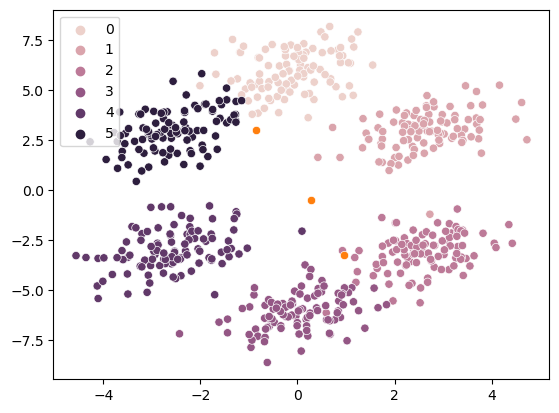

In [147]:
koh.plot_clusters(labels=hexagon['c'])

Używanie liczby K mniejszej niż liczba klas jest bez sensu, gdyż nie mamy szans wykrycia wszystkich klastrów. V-measure wynosi 0.53

In [43]:
# K = C

In [174]:
koh = KOH(2, (3, 2))

In [175]:
koh.train(hex_train, lambda_max=10)

In [176]:
preds = koh.predict(hex_train)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(hexagon['c'].to_numpy(), preds))

clusters: 6
v measure: 0.8201287805185917


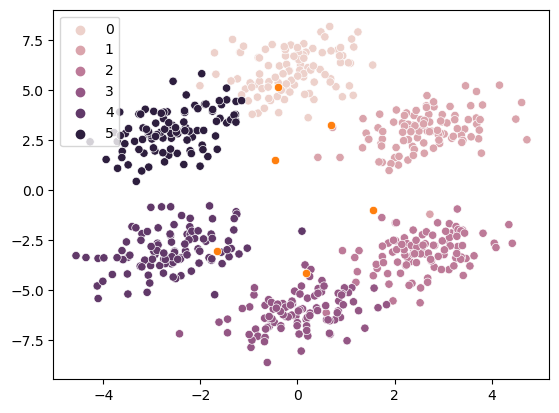

In [177]:
koh.plot_clusters(labels=hexagon['c'])

Użycie K = C ma największy sens, gdyż wtedy każdy neuron odpowiada jednemu klastrowi

In [54]:
# K > C

In [186]:
koh = KOH(2, (4, 3))

In [187]:
koh.train(hex_train, lambda_max=10)

In [188]:
preds = koh.predict(hex_train)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(hexagon['c'].to_numpy(), preds))

clusters: 12
v measure: 0.805309483533338


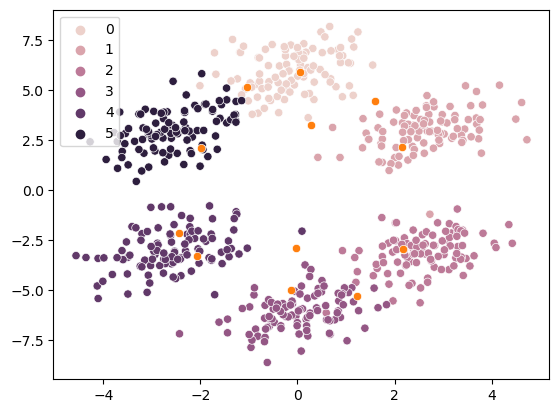

In [189]:
koh.plot_clusters(labels=hexagon['c'])

Widzimy że przy użyciu gęstszej siatki dostajemy dobre wyniki. Już przy 10 iteracjach punkty siatki osadzają się na klastrach. Normalnie nie znamy prawdziwej ilości klastrów, ale widzimy że lepiej zawyżać liczbę neuronów niż zaniżać.

Sprawdźmy, jak działa parametr r

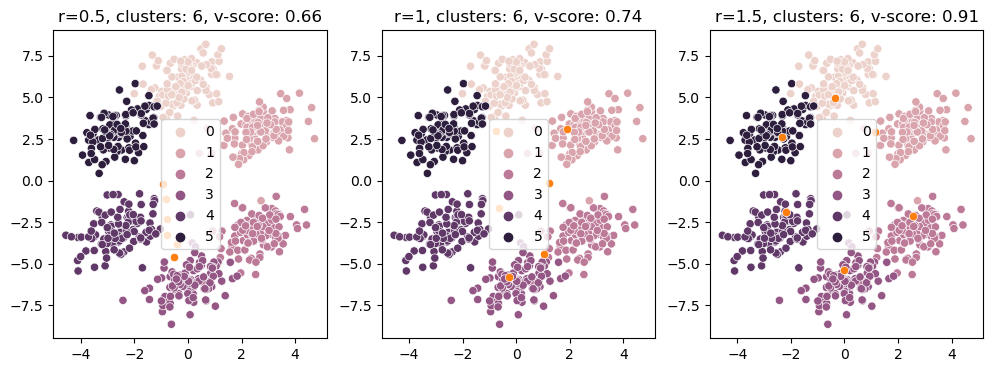

In [190]:
plt.figure(figsize=(12,4))
r_values = [0.5, 1, 1.5]
for i, r in enumerate(r_values):
    koh = KOH(2, (3, 2))
    koh.train(hex_train, lambda_max=5, r=r)
    preds = koh.predict(hex_train)
    plt.subplot(1, 3, i+1)
    plt.title(f"r={r}, clusters: {len(np.unique(preds))}, v-score: {round(v_measure_score(hexagon['c'].to_numpy(), preds), 2)}")
    koh.plot_clusters(labels=hexagon['c'], return_plot=True)

#### Meksykański kapelusz

C:\Users\tymoteusz.urban\AppData\Local\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2542: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
C:\Users\tymoteusz.urban\AppData\Local\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2541: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
C:\Users\tymoteusz.urban\AppData\Local\Temp\ipykernel_11892\3877245774.py:57: RuntimeWarning: overflow encountered in add
  self.weights = self.weights + exp_decay(t, lambda_max) * nhood_weights_tensor * (x - self.weights)


clusters: 1
v measure: 0.0


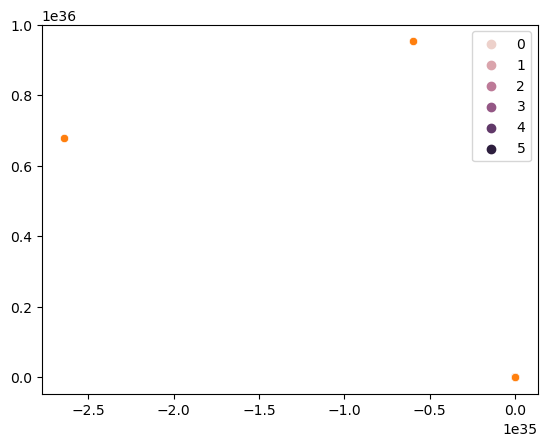

In [260]:
koh = KOH(2, (4, 3), neighborhood_function=mexican_hat_nhood)
koh.train(hex_train, lambda_max=20)
preds = koh.predict(hex_train)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(hexagon['c'].to_numpy(), preds))
koh.plot_clusters(labels=hexagon['c'])

In [262]:
# Na domyślnych parametrach meksykański kapelusz jest bardzo niestabilny, wyrzuca punkty do ogromnych wartości. 
# Spróbujmy skorzystać z neighborhood decay:

clusters: 2
v measure: 0.5198447819543425


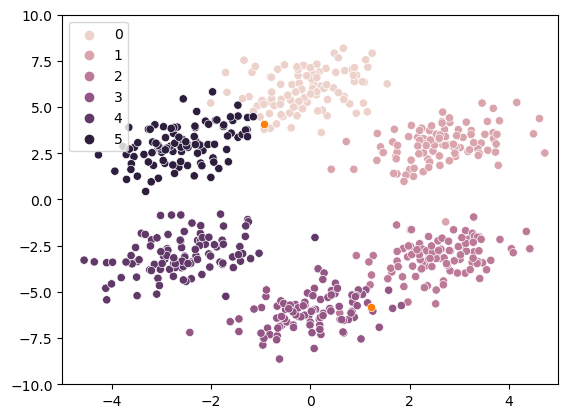

In [258]:
koh = KOH(2, (4, 3), neighborhood_function=mexican_hat_nhood)
koh.train(hex_train, lambda_max=20, use_nhood_decay=True)
preds = koh.predict(hex_train)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(hexagon['c'].to_numpy(), preds))
koh.plot_clusters(labels=hexagon['c'], return_plot=True)
plt.xlim(-5, 5)
plt.ylim(-10, 10)
plt.show()

In [265]:
# Widzimy, że jest lepiej. Nie dostajemy warningów, część neuronów "została na miejscu", i v measure nie jest równy 0. 
# Spróbujmy wziąć gęstszą siatkę:

clusters: 6
v measure: 0.8528983199727501


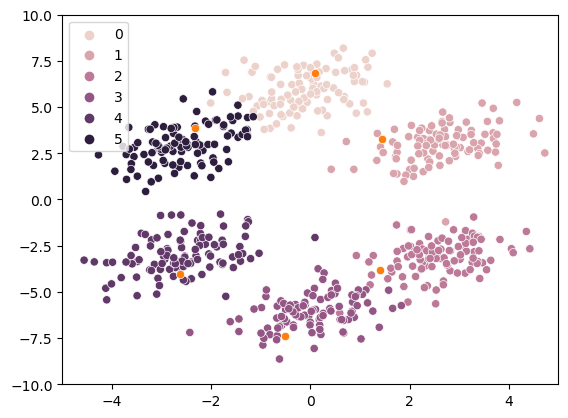

In [264]:
koh = KOH(2, (12, 6), neighborhood_function=mexican_hat_nhood)
koh.train(hex_train, lambda_max=20, use_nhood_decay=True)
preds = koh.predict(hex_train)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(hexagon['c'].to_numpy(), preds))
koh.plot_clusters(labels=hexagon['c'], return_plot=True)
plt.xlim(-5, 5)
plt.ylim(-10, 10)
plt.show()

In [267]:
# sprawdźmy, czy nie był to przypadek

In [22]:
clusters=[]
v_ms=[]
for i in range(6):
    koh = KOH(2, (random.randint(6, 12), random.randint(6, 12)), neighborhood_function=mexican_hat_nhood)
    koh.train(hex_train, lambda_max=20, use_nhood_decay=True)
    preds = koh.predict(hex_train)
    clusters.append(len(np.unique(preds)))
    v_ms.append(v_measure_score(hexagon['c'].to_numpy(), preds))
print('n clusters mode:', statistics.mode(clusters))
print('average v score:', np.mean(v_ms))
print('v score std deviation:', np.std(v_ms))

n clusters mode: 6
average v score: 0.8265098720083631
v score std deviation: 0.046691249729542014


In [277]:
# Widzimy zatem, że nie znając liczby klastrów możemy podać bardzo gęstą siatkę (ponad 10 razy więcej neuronów niż
# prawdziwych klastrów), a sieć i tak znajdzie tą optymalną liczbę, a resztę neuronów wyrzuci "na zewnątrz" danych. 

### Cube dataset

In [279]:
# K < C

clusters: 4
v measure: 0.692787978908058


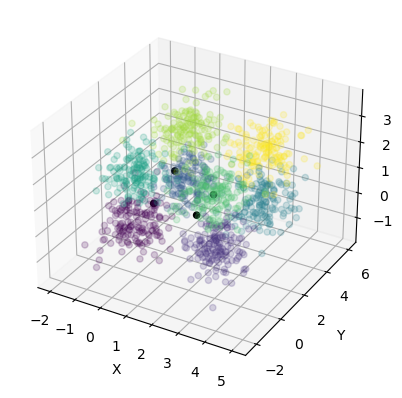

In [278]:
koh = KOH(3, (2, 2))
koh.train(cube_train, lambda_max=10)
preds = koh.predict(cube_train)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(cube['c'].to_numpy(), preds))
koh.plot_clusters(labels=cube['c'], type='cube')

In [280]:
# K = C

r parameter value: 0.5
clusters: 8
v measure: 0.5919334618628836


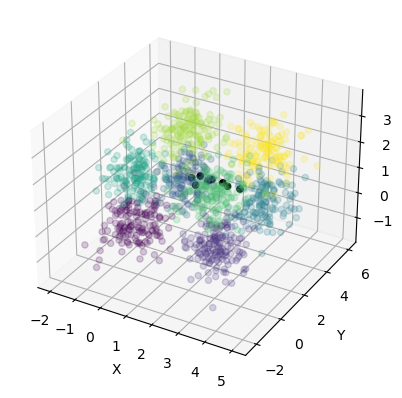

r parameter value: 1
clusters: 8
v measure: 0.6959072052002095


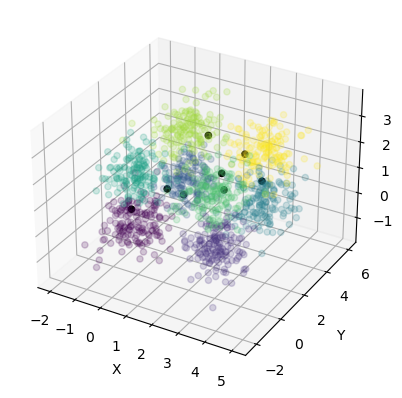

r parameter value: 1.2
clusters: 8
v measure: 0.7525840527052939


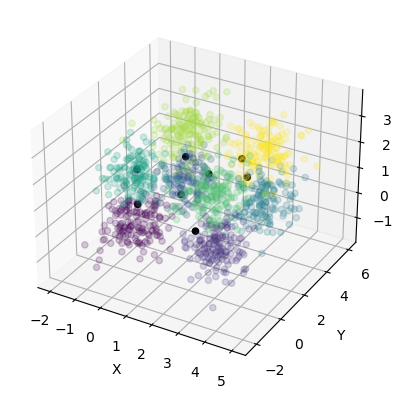

r parameter value: 1.6
clusters: 8
v measure: 0.8795434496062134


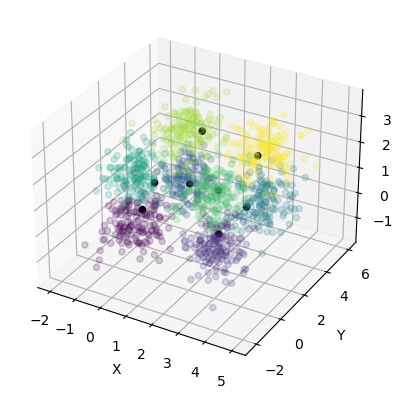

In [292]:
r_values = [0.5, 1, 1.2, 1.6]
for r in r_values:
    print('r parameter value:', r)
    koh = KOH(3, (4, 2))
    koh.train(cube_train, lambda_max=5, r=r)
    preds = koh.predict(cube_train)
    print('clusters:', len(np.unique(preds)))
    print('v measure:', v_measure_score(cube['c'].to_numpy(), preds))
    koh.plot_clusters(labels=cube['c'], type='cube')

In [293]:
# widzimy, że zawężanie oddziaływanie funkcji przyciągania i ustawianie parametru r na większy od 1,
# daje lepsze wyniki klasteryzacji.

In [294]:
# K > C

clusters: 24
v measure: 0.7256618138807662


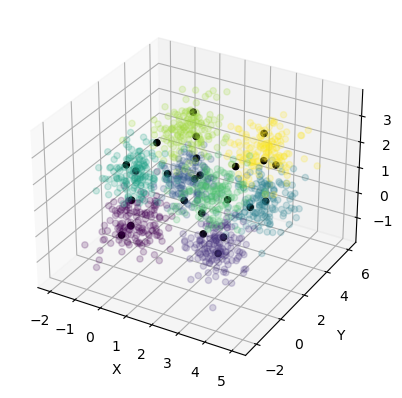

In [302]:
koh = KOH(3, (6, 4))
koh.train(cube_train, lambda_max=10, r=2)
preds = koh.predict(cube_train)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(cube['c'].to_numpy(), preds))
koh.plot_clusters(labels=cube['c'], type='cube')

In [23]:
# Na koniec zobaczmy meksykański kapelusz na zestawie danych cube:

In [44]:
clusters=[]
v_ms=[]
for i in range(6):
    koh = KOH(3, (random.randint(6, 12), random.randint(6, 12)), neighborhood_function=mexican_hat_nhood)
    koh.train(cube_train, lambda_max=20, use_nhood_decay=True)
    preds = koh.predict(cube_train)
    clusters.append(len(np.unique(preds)))
    v_ms.append(v_measure_score(cube['c'].to_numpy(), preds))
print('n clusters mode:', statistics.mode(clusters))
print('average v score:', np.mean(v_ms))
print('v score std deviation:', np.std(v_ms))

n clusters mode: 6
average v score: 0.747177206125548
v score std deviation: 0.06122397506123646


## KOH 2

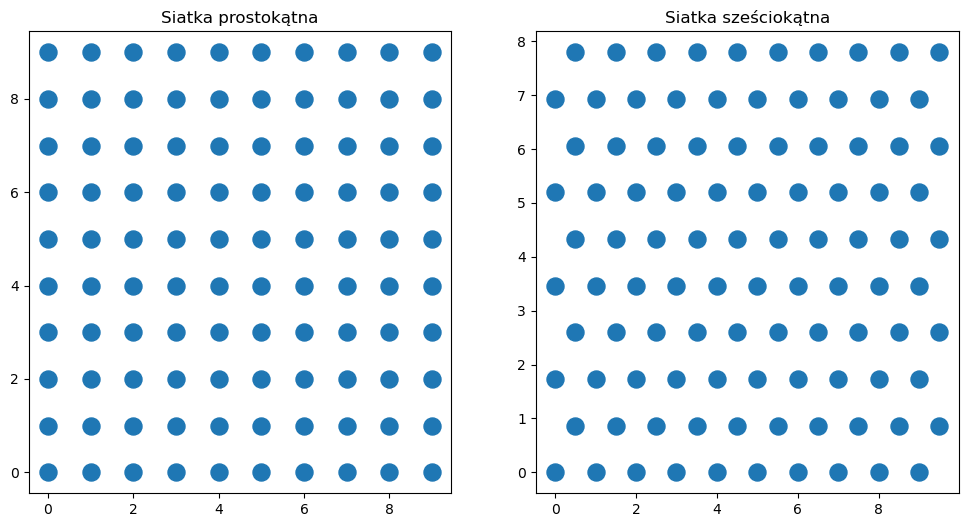

In [171]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
koh = KOH(2, (10,10))
plt.scatter(koh.indices[:,1], koh.indices[:,0], s=150)
plt.title("Siatka prostokątna")
plt.subplot(1, 2, 2)
koh = KOH(2, (10,10), topology='hexagonal')
plt.scatter(koh.indices[:,1], koh.indices[:,0], s=150)
plt.title("Siatka sześciokątna")
plt.show()

#### MNIST

In [177]:
from keras.datasets import mnist
(mnist_x_raw, mnist_y_raw), (mnist_test_x, mnist_test_y) = mnist.load_data()
mnist_x = mnist_x_raw.reshape(-1, 784)

In [194]:
# prostokatna

In [184]:
mnist_koh_hex = KOH(784, (2,5))
mnist_koh_hex.train(mnist_x, lambda_max=10, use_nhood_decay=True)
preds = mnist_koh_hex.predict(mnist_x)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(mnist_y_raw, preds))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:44<00:00, 40.49s/it]


clusters: 10
v measure: 0.3681953981780459


In [186]:
mnist_koh_hex = KOH(784, (2,5))
mnist_koh_hex.train(mnist_x, lambda_max=20, use_nhood_decay=True)
preds = mnist_koh_hex.predict(mnist_x)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(mnist_y_raw, preds))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [13:23<00:00, 40.16s/it]


clusters: 10
v measure: 0.357046801181069


In [185]:
mnist_koh_hex = KOH(784, (2,5))
mnist_koh_hex.train(mnist_x, lambda_max=10)
preds = mnist_koh_hex.predict(mnist_x)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(mnist_y_raw, preds))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:44<00:00, 40.44s/it]


clusters: 10
v measure: 0.29086285892933667


In [ ]:
# szesciokatna

In [187]:
mnist_koh_hex = KOH(784, (2,5), topology='hexagonal')
mnist_koh_hex.train(mnist_x, lambda_max=10, use_nhood_decay=True)
preds = mnist_koh_hex.predict(mnist_x)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(mnist_y_raw, preds))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:44<00:00, 40.45s/it]


clusters: 10
v measure: 0.30077579652171815


In [193]:
mnist_koh_hex = KOH(784, (2,5), topology='hexagonal')
mnist_koh_hex.train(mnist_x, lambda_max=10, use_nhood_decay=True)
preds = mnist_koh_hex.predict(mnist_x)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(mnist_y_raw, preds))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:43<00:00, 40.31s/it]


clusters: 10
v measure: 0.29445537148225825


In [195]:
mnist_koh_hex = KOH(784, (2,5), topology='hexagonal')
mnist_koh_hex.train(mnist_x, lambda_max=10)
preds = mnist_koh_hex.predict(mnist_x)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(mnist_y_raw, preds))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:42<00:00, 40.23s/it]


clusters: 10
v measure: 0.3050320646098043


In [ ]:
# meksykanski kapelusz

In [192]:
mnist_koh_hex = KOH(784, (8, 8), neighborhood_function=mexican_hat_nhood)
mnist_koh_hex.train(mnist_x, lambda_max=10, use_nhood_decay=True, r=0.8)
preds = mnist_koh_hex.predict(mnist_x)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(mnist_y_raw, preds))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\ProgramData\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2583: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))
C:\ProgramData\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
C:\Users\tymek\AppData\Local\Temp\ipykernel_16108\3214388511.py:58: RuntimeWarning: overflow encountered in add
  self.weights = self.weights + exp_decay(t, lambda_max) * nhood_weights_tensor * (x - self.weights)
 30%|████████████████████████▉                                                          | 3/10 [02:38<06:06, 52.42s/it]C:\Users\tymek\AppData\Local\Temp\ipykernel_16108\3214388511.py:58: RuntimeWarning: invalid value encountered in multiply
  self.weights = self.weights + exp_decay(t, lambda_max) * nhood_weights_tensor * (x - self.weights)
1

clusters: 1
v measure: 0.0


In [ ]:
# niestety, pomimo wielu prób z różnymi wartościami parametrów nie udało się przeprowadzić udanego treningu bez błędów

In [196]:
# K < C
mnist_koh_hex = KOH(784, (3, 2))
mnist_koh_hex.train(mnist_x, lambda_max=10)
preds = mnist_koh_hex.predict(mnist_x)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(mnist_y_raw, preds))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:37<00:00, 39.78s/it]


clusters: 6
v measure: 0.2284834872387832


In [197]:
# K > C
mnist_koh_hex = KOH(784, (8, 8))
mnist_koh_hex.train(mnist_x, lambda_max=10)
preds = mnist_koh_hex.predict(mnist_x)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(mnist_y_raw, preds))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:15<00:00, 49.59s/it]


clusters: 64
v measure: 0.4356114449987225


### HARUS

In [ ]:
# 6 klastrów  (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING)

In [10]:
def read_harus(path):
    with open(path, 'r') as file:
        data = [[float(x) for x in line.split()] for line in file]
    return np.array(data)

harus_x = read_harus('dane/uci_har_dataset/train/X_train.txt')
harus_x.shape

(7352, 561)

In [15]:
harus_y_raw = read_harus('dane/uci_har_dataset/train/y_train.txt')
harus_y = harus_y_raw.flatten()

In [18]:
harus_koh = KOH(561, (2,3))
harus_koh.train(harus_x, lambda_max=10, use_nhood_decay=True)
preds = harus_koh.predict(harus_x)
print('clusters:', len(np.unique(preds)))
print('v measure:', v_measure_score(harus_y, preds))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.56s/it]

clusters: 6
v measure: 0.5972399920723502


In [20]:
vms = []
for i in range(3):
    harus_koh = KOH(561, (2,3))
    harus_koh.train(harus_x, lambda_max=10, use_nhood_decay=True)
    preds = harus_koh.predict(harus_x)
    vms.append(v_measure_score(harus_y, preds))
print(np.mean(vms))
print(np.std(vms))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.59s/it]

0.5747700774942913
0.017542346956442068


In [21]:
vms = []
for i in range(3):
    harus_koh = KOH(561, (2,3), topology='hexagonal')
    harus_koh.train(harus_x, lambda_max=10, use_nhood_decay=True)
    preds = harus_koh.predict(harus_x)
    vms.append(v_measure_score(harus_y, preds))
print(np.mean(vms))
print(np.std(vms))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.59s/it]

0.6228626885095748
0.008853979281295329


In [ ]:
# lepsza jest topologia ... , teraz sprawdzimy funkcje sąsiedztwa

In [37]:
vms = []
for i in range(3):
    harus_koh = KOH(561, (2,3), topology='hexagonal', neighborhood_function=mexican_hat_nhood)
    harus_koh.train(harus_x, lambda_max=5, use_nhood_decay=True, learning_rate=0.01, r=0.1)
    preds = harus_koh.predict(harus_x)
    vms.append(v_measure_score(harus_y, preds))
print(np.mean(vms))
print(np.std(vms))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.64s/it]

0.48927456164996513
0.010514027037390742


In [35]:
# K < C
vms = []
for i in range(5):
    harus_koh = KOH(561, (1,3), topology='hexagonal')
    harus_koh.train(harus_x, lambda_max=10, use_nhood_decay=True)
    preds = harus_koh.predict(harus_x)
    vms.append(v_measure_score(harus_y, preds))
print(np.mean(vms))
print(np.std(vms))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:35<00:00,  3.57s/it]

0.5258177115454215
0.010253000883886322


In [36]:
# K > C
vms = []
for i in range(5):
    harus_koh = KOH(561, (6,4), topology='hexagonal')
    harus_koh.train(harus_x, lambda_max=10, use_nhood_decay=True)
    preds = harus_koh.predict(harus_x)
    vms.append(v_measure_score(harus_y, preds))
print(np.mean(vms))
print(np.std(vms))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.86s/it]


0.5166060658228977
0.07302518730504987
